In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
weights_path = "/content/drive/My Drive/colab_notebooks/data/lstmae.hdf5"
zip_ref = zipfile.ZipFile("/content/drive/My Drive/colab_notebooks/data/ppg.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [3]:
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import scipy
print(scipy.__version__)

1.21.6
1.7.3


### Reading data

In [4]:
with open('/tmp/trainppg.pkl','rb') as f:
    X_train = pkl.load(f)
    print("X train shape: " , X_train.shape)

with open('/tmp/trainlabels.pkl','rb') as f:
    labels_train = pkl.load(f)
    labels_train=labels_train^1
    print("labels_train shape: " , labels_train.shape)
    
with open('/tmp/testppg.pkl','rb') as f:
    X_test = pkl.load(f)
    print("X test shape: " , X_test.shape)

X train shape:  (19088, 312, 1)
labels_train shape:  (19088,)
X test shape:  (150, 312, 1)


[]

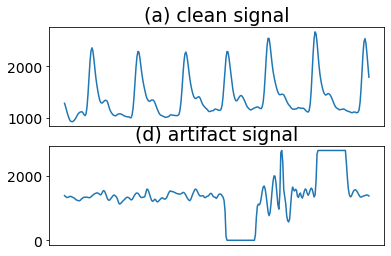

In [5]:
# where label is 0 means it is clean
fig, axs = plt.subplots(2, 1)
axs[0].plot(X_train[np.where(labels_train == 0)[0][0]].flatten())
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title("(a) clean signal",fontsize=19)
axs[0].set_xticks([])

# where label is 1 means it is noisy
axs[1].plot(X_train[np.where(labels_train == 1)[0][160]].flatten())
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_title("(d) artifact signal",fontsize=19)
axs[1].set_xticks([])


[]

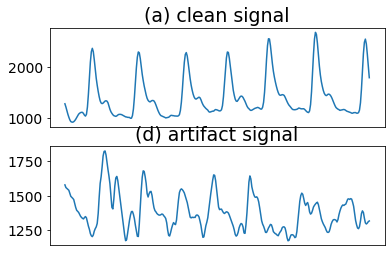

In [6]:
# where label is 0 means it is clean
fig, axs = plt.subplots(2, 1)
axs[0].plot(X_train[np.where(labels_train == 0)[0][0]].flatten())
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title("(a) clean signal",fontsize=19)
axs[0].set_xticks([])

# where label is 1 means it is noisy
axs[1].plot(X_train[np.where(labels_train == 1)[0][1]].flatten())
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_title("(d) artifact signal",fontsize=19)
axs[1].set_xticks([])


The above picture shows that the artifact signal is, in fact, a clean signal with some noise. This is a mislabeled window. Several windows exist like this one, which could explain why we may have several false negatives (signals labeled as artifacts but classified as clean).

In [7]:
unique, counts = np.unique(labels_train, return_counts=True)
dict(zip(unique, counts))

{0: 14570, 1: 4518}

We have 14570 clean PPG windows and 4518 noisy windows. 

### Downsampling with wavelets

In [8]:
import pywt
def wavelet_transform(X_train,X_test):
    c=0.5
    dec_lo, dec_hi, rec_lo, rec_hi = [c, c], [-c, c], [c, c], [c, -c]
    filter_bank = [dec_lo, dec_hi, rec_lo, rec_hi]
    myWavelet = pywt.Wavelet(name="myHaarWavelet", filter_bank=filter_bank)
    myWavelet = pywt.Wavelet(name="haar")
    X_train_coeff = np.zeros((X_train.shape[0], int(X_train.shape[1]/4), 1))
    x_ch=0
    i=0
    while i < X_train.shape[0]:
        cA, cD =pywt.dwt(X_train[i].flatten(), myWavelet)
        cA, cD =pywt.dwt(cA, myWavelet)
        X_train_coeff[x_ch,:,:] = cA.reshape(len(cA),1)
        x_ch += 1
        i+=1
    X_test_coeff = np.zeros((X_test.shape[0], int(X_test.shape[1]/4), 1))
    x_ch=0
    i=0
    while i < X_test.shape[0]:
        cA, cD =pywt.dwt(X_test[i].flatten(), myWavelet)
        cA, cD =pywt.dwt(cA, myWavelet)
        X_test_coeff[x_ch,:,:] = cA.reshape(len(cA),1)
        x_ch += 1
        i+=1
    return X_train_coeff,X_test_coeff

In [9]:
#Get Wavelet coefficients
X_train,X_test = wavelet_transform(X_train,X_test)
print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape)

X train shape:  (19088, 78, 1)
X test shape:  (150, 78, 1)


The size of each PPG window is reduced from 312 to 78

[]

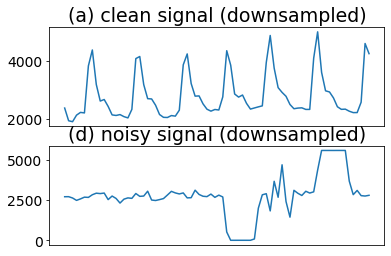

In [10]:
# where label is 0 means it is clean
fig, axs = plt.subplots(2, 1)
axs[0].plot(X_train[np.where(labels_train == 0)[0][0]].flatten())
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title("(a) clean signal (downsampled)",fontsize=19)
axs[0].set_xticks([])

# where label is 1 means it is noisy
axs[1].plot(X_train[np.where(labels_train == 1)[0][160]].flatten())
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_title("(d) noisy signal (downsampled)",fontsize=19)
axs[1].set_xticks([])

### Split the training set into training-validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train_ae, X_val_ae, Y_train_ae, Y_val_ae = train_test_split(X_train, labels_train, test_size=0.3,random_state=8)

print("Training set")
print(pd.Series(Y_train_ae).value_counts())
print("Testing set")
print(pd.Series(Y_val_ae).value_counts())

Training set
0    10212
1     3149
dtype: int64
Testing set
0    4358
1    1369
dtype: int64


For training the autoencoder, we will be using the X coming from only the negatively labeled data. Therefore, we separate the X corresponding to y = 0.



In [13]:
X_train_y0 = X_train_ae[Y_train_ae==0]
X_train_y1 = X_train_ae[Y_train_ae==1]
X_valid_y0 = X_val_ae[Y_val_ae==0]
X_valid_y1 = X_val_ae[Y_val_ae==1]

print("X_train_y0 ", X_train_y0.shape)
print("X_train_y1 ", X_train_y1.shape)
print("X_valid_y0 ", X_valid_y0.shape)
print("X_valid_y1 ", X_valid_y1.shape)

X_train_y0  (10212, 78, 1)
X_train_y1  (3149, 78, 1)
X_valid_y0  (4358, 78, 1)
X_valid_y1  (1369, 78, 1)


### Data augmentation (only the clean PPG windows)

#### Gaussian noise

In [14]:
#generate gaussian noise
noise = 30*np.random.randn(X_train_y0.shape[0],X_train_y0.shape[1],X_train_y0.shape[2]) + 10
X_temp=X_train_y0+noise

X_train_ae=np.concatenate((X_train_ae,X_temp),axis=0)
Y_train_ae=np.append(Y_train_ae,np.zeros(X_temp.shape[0]))

[]

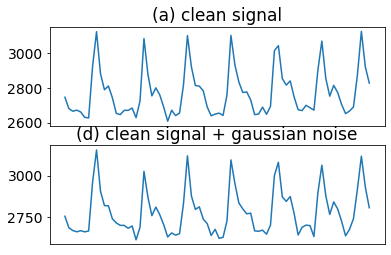

In [15]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(X_train_y0[0].flatten())
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title("(a) clean signal",fontsize=17)
axs[0].set_xticks([])

axs[1].plot(X_temp[0].flatten())
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_title("(d) clean signal + gaussian noise",fontsize=17)
axs[1].set_xticks([])

#### Uniform noise

In [16]:
#generate uniform noise
noise = 150*np.random.rand(X_train_y0.shape[0],X_train_y0.shape[1],X_train_y0.shape[2]) + 50
X_temp=X_train_y0+noise

X_train_ae=np.concatenate((X_train_ae,X_temp),axis=0)
Y_train_ae=np.append(Y_train_ae,np.zeros(X_temp.shape[0]))

[]

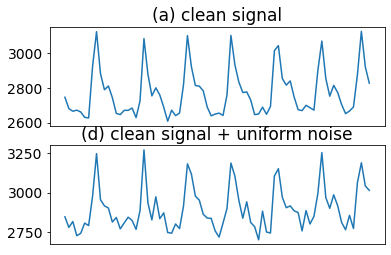

In [17]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(X_train_y0[0].flatten())
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title("(a) clean signal",fontsize=17)
axs[0].set_xticks([])

axs[1].plot(X_temp[0].flatten())
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_title("(d) clean signal + uniform noise",fontsize=17)
axs[1].set_xticks([])

#### Scaling

In [18]:
#Scaling
def DA_Scaling(X, sigma=0.5):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise
    
X_temp=np.zeros((X_train_y0.shape[0],X_train_y0.shape[1],X_train_y0.shape[2]))
for i in range(X_train_y0.shape[0]):
    X_temp[i]=DA_Scaling(X_train_y0[i])
    
X_train_ae=np.concatenate((X_train_ae,X_temp),axis=0)
Y_train_ae=np.append(Y_train_ae,np.zeros(X_temp.shape[0]))

[]

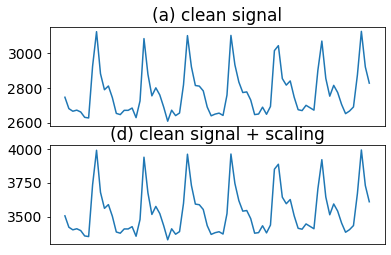

In [19]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(X_train_y0[0].flatten())
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title("(a) clean signal",fontsize=17)
axs[0].set_xticks([])

axs[1].plot(X_temp[0].flatten())
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_title("(d) clean signal + scaling",fontsize=17)
axs[1].set_xticks([])

#### Magnitude-warping

In [20]:
#Magnitude Warping
from scipy.interpolate import CubicSpline 
def GenerateRandomCurves(X, sigma=0.2, knot=1):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    return np.array([cs_x(x_range)]).transpose()


def DA_MagWarp(X, sigma=0.1):
    return X * GenerateRandomCurves(X, sigma)

X_temp=np.zeros((X_train_y0.shape[0],X_train_y0.shape[1],X_train_y0.shape[2]))
for i in range(X_train_y0.shape[0]):
    X_temp[i]=DA_MagWarp(X_train_y0[i])
    
X_train_ae=np.concatenate((X_train_ae,X_temp),axis=0)
Y_train_ae=np.append(Y_train_ae,np.zeros(X_temp.shape[0]))

[]

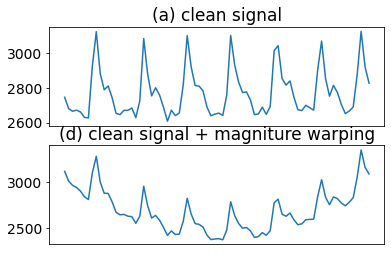

In [21]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(X_train_y0[0].flatten())
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title("(a) clean signal",fontsize=17)
axs[0].set_xticks([])

axs[1].plot(X_temp[0].flatten())
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_title("(d) clean signal + magniture warping",fontsize=17)
axs[1].set_xticks([])

#### Pink noise  

In [22]:
X_temp=np.zeros((X_train_y0.shape[0],X_train_y0.shape[1],X_train_y0.shape[2]))
import scipy.fftpack
for i in range(X_train_y0.shape[0]):
    ed = 35
    # 1/f amplitude spectrum
    asi = np.multiply(10*np.random.rand(int(np.floor(X_train_y0.shape[1]/2)-1)) , .1+np.exp(-np.arange(0,int(np.floor(X_train_y0.shape[1]/2)-1))/ed) )
    asi = np.concatenate( (np.asarray([asi[0]]),asi,np.asarray([0]),asi[::-1]),axis=0 )
    # Fourier coefficients
    fc = np.multiply( asi , np.exp(1j*2*np.pi*np.random.rand(len(asi))) )
    # inverse Fourier transform to create the noise
    noise = np.real(scipy.fftpack.ifft(fc)) * X_train_y0.shape[1]
    X_temp[i]=X_train_y0[i] + noise.reshape(len(noise),1)


X_train_ae=np.concatenate((X_train_ae,X_temp),axis=0)
Y_train_ae=np.append(Y_train_ae,np.zeros(X_temp.shape[0]))

[]

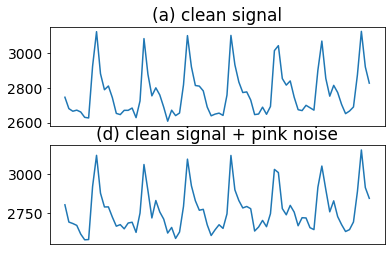

In [23]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(X_train_y0[0].flatten())
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title("(a) clean signal",fontsize=17)
axs[0].set_xticks([])

axs[1].plot(X_temp[0].flatten())
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_title("(d) clean signal + pink noise",fontsize=17)
axs[1].set_xticks([])

#### Brownian noise  

In [24]:
X_temp=np.zeros((X_train_y0.shape[0],X_train_y0.shape[1],X_train_y0.shape[2]))
for i in range(X_train_y0.shape[0]):
    rnoise = 20*np.random.randn(X_train_y0.shape[1]) + 2
    noise  = np.cumsum(rnoise)
    X_temp[i]=X_train_y0[i] + noise.reshape(len(noise),1)

X_train_ae=np.concatenate((X_train_ae,X_temp),axis=0)
Y_train_ae=np.append(Y_train_ae,np.zeros(X_temp.shape[0]))

[]

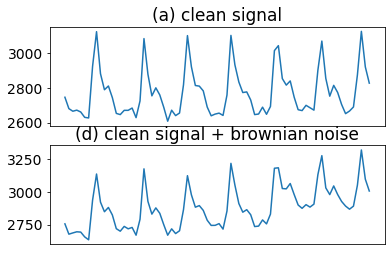

In [25]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(X_train_y0[0].flatten())
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_title("(a) clean signal",fontsize=17)
axs[0].set_xticks([])

axs[1].plot(X_temp[0].flatten())
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_title("(d) clean signal + brownian noise",fontsize=17)
axs[1].set_xticks([])

In [26]:
print("Training Set after Augmentation")
print()
print(pd.Series(Y_train_ae).value_counts())
del(X_temp)

X_train_y0 = X_train_ae[Y_train_ae==0]
X_train_y1 = X_train_ae[Y_train_ae==1]


print("X_train_y0 afer data augmentation ", X_train_y0.shape)
print("X_train_y1 afer data augmentation ", X_train_y1.shape)

Training Set after Augmentation

0.0    71484
1.0     3149
dtype: int64
X_train_y0 afer data augmentation  (71484, 78, 1)
X_train_y1 afer data augmentation  (3149, 78, 1)


### Standardization

In [27]:
def standardize(train,val,test):
     mean=np.mean(train, axis=0)[None,:,:]
     std=np.std(train, axis=0)[None,:,:]
     # standardize train, val, and test
     X_train = (train - mean) / std
     X_val = (val - mean) / std
     X_test = (test - mean) / std
     return X_train,X_val, X_test, mean, std

def scale(X,mean,std):
  X_scaled = (X - mean) / std
  return X_scaled


In [28]:
X_train_y0,X_val_ae,X_test, mean, std = standardize(X_train_y0,X_val_ae, X_test)
X_valid_y0 = scale(X_valid_y0,mean,std)
X_valid_y1 = scale(X_valid_y1,mean,std)
X_train_y1 = scale(X_train_y1,mean,std)


print('colwise mean', np.mean(X_train_y0, axis=0)[None,:,:].round(6))
print('colwise variance', np.var(X_train_y0, axis=0)[None,:,:])

colwise mean [[[-0.]
  [ 0.]
  [-0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [-0.]
  [ 0.]
  [-0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [-0.]
  [ 0.]
  [ 0.]
  [-0.]
  [ 0.]
  [-0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [-0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [-0.]
  [-0.]
  [-0.]
  [-0.]
  [-0.]
  [ 0.]
  [-0.]
  [-0.]
  [ 0.]
  [-0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [-0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [-0.]
  [ 0.]
  [-0.]
  [-0.]
  [-0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [-0.]
  [-0.]
  [ 0.]
  [-0.]
  [-0.]
  [ 0.]
  [ 0.]
  [-0.]
  [-0.]
  [ 0.]
  [-0.]
  [ 0.]
  [-0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [-0.]
  [ 0.]
  [-0.]
  [-0.]
  [ 0.]
  [ 0.]]]
colwise variance [[[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
 

All the means and variances outputted above are 0 and 1, respectively. Therefore, the scaling is correct.

### Time-Frequency transformation

In [29]:
# Copied From https://github.com/BMClab/BMC/blob/master/notebooks/DetectPeaks.ipynb
# Thank you Marcos Duarte

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.
    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 
    See this IPython Notebook [1]_.
    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)
    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)
    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)
    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])
    return ind

Before downsampling: 


*   Fs = 52 Hz
*   Window = Fs x 6 = 312 samples

After downsampling: 



*   Fs = 13 Hz
*   Window = Fs x 6 = 78 samples



We will divide each window into two : 2 windows of (Fs x 3) = 39 samples

The objective is to pass from a tensor of (num samples, 78 , 1) 
to (num samples, Fs x 3 = 39, num features)

In this example, the features are extracted using the Discrete Fourier Transform. 

In [30]:
t_n = 3 # each sub-window = 3 seconds
N = int(X_train_y0.shape[1]/2) # number of elements in each sub-window = 78/2 = 39
T = t_n / N # period
f_s = 1/T # frequency

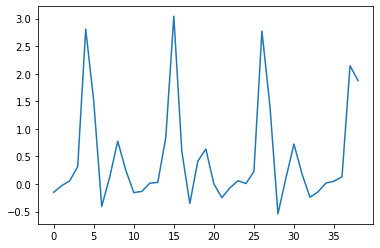

In [31]:
i = 30699
signal_test = X_train_y0[i,:N,0].flatten()
plt.plot(signal_test)

[ 4 15 26 37]
Average time difference between peaks:  0.8461538461538461


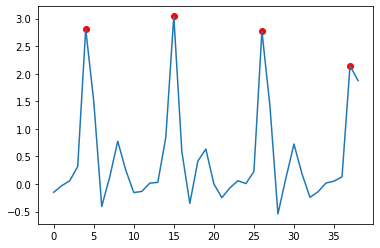

In [32]:
def get_mph(signal, percentile): #min peak height
  signal_min = np.nanpercentile(signal, percentile)
  signal_max = np.nanpercentile(signal, 100-percentile)
  #(100 - 2*percentile)/10
  mph = signal_min + (signal_max - signal_min)/10 #minimum peak height
  return mph

mph = get_mph(signal_test,90)
# average time difference between peaks
def get_avg_timediff(signal, mph, N,t_n):
  ind = detect_peaks(signal,mph)
  if len(ind) == 0:
    return 0
  if len(ind) == 1:
    return 0
  avgdiff = np.mean(np.diff(ind))
  return (avgdiff*t_n)/N



ind = detect_peaks(signal_test,mph)
print(ind)

plt.plot(signal_test)
plt.scatter(ind,signal_test[ind],color="red")
print("Average time difference between peaks: ", get_avg_timediff(signal_test,mph,N,t_n))

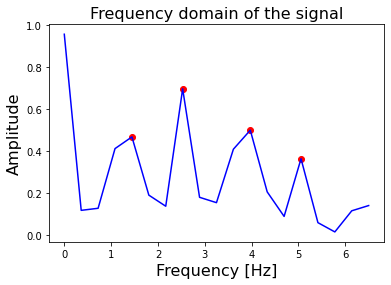

In [33]:
from scipy.fftpack import fft
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values



# Example
f_values, fft_values = get_fft_values(signal_test, T, N, f_s)

ind = detect_peaks(fft_values,get_mph(fft_values,5))
plt.scatter(f_values[ind],fft_values[ind],color="red")
plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()


Since our signal in each sub-window is sampled at a rate f_s of 13 Hz, the FFT will return the frequency spectrum up to a frequency of f_s / 2 = 6 Hz. 

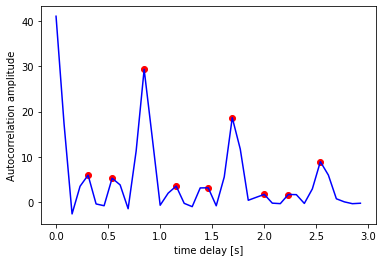

In [34]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

t_values, autocorr_values = get_autocorr_values(signal_test, T, N, f_s)

ind = detect_peaks(autocorr_values,get_mph(fft_values,5))
plt.scatter(t_values[ind],autocorr_values[ind],color="red")

plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')
plt.show()

In [35]:
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph,no_peaks=5):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks],no_peaks)
    return peaks_x + peaks_y
 
def extract_features(signal, T, N, f_s):
    features = []
    mph = get_mph(signal,5)
    features += get_features(*get_fft_values(signal, T, N, f_s), mph, 4)
    features += get_features(*get_autocorr_values(signal, T, N, f_s), mph, 3)
    features += [get_avg_timediff(signal,get_mph(signal,90),N,t_n)]
    return np.array(features)

In [36]:
def transform_tensors(X, T, N, f_s):
  X_features = []
  for i in range(len(X)):
    windows = []
    windows.append(extract_features(X[i,:N,0].flatten(), T, N, f_s))
    windows.append(extract_features(X[i,N:,0].flatten(), T, N, f_s))
    X_features.append(windows)
  return np.array(X_features)

X_train_y0_features = transform_tensors(X_train_y0, T, N, f_s)
print("X_train_y0_features ", X_train_y0_features.shape)

X_train_y0_features  (71484, 2, 15)


In [37]:
print(X_train_y0_features[0,0,:])
print(X_train_y0_features[0,1,:])

[1.08333333 2.52777778 3.61111111 4.33333333 0.15288855 0.0608652
 0.09100142 0.04357744 0.92307692 1.76923077 2.46153846 0.72817294
 0.54569433 0.14452601 0.88461538]
[1.44444444 2.52777778 3.61111111 4.69444444 0.14721007 0.11112465
 0.06415328 0.03435428 0.84615385 1.69230769 2.53846154 0.82818496
 0.50675191 0.25536102 0.84615385]


In [38]:
X_val_ae_features = transform_tensors(X_val_ae, T, N, f_s)
X_valid_y0_features = transform_tensors(X_valid_y0, T, N, f_s)
X_valid_y1_features = transform_tensors(X_valid_y1, T, N, f_s)
print("X_val_ae_features ", X_val_ae_features.shape)
print("X_valid_y0_features ", X_valid_y0_features.shape)
print("X_valid_y1_features ", X_valid_y1_features.shape)

X_val_ae_features  (5727, 2, 15)
X_valid_y0_features  (4358, 2, 15)
X_valid_y1_features  (1369, 2, 15)


In [39]:
X_test_features = transform_tensors(X_test, T, N, f_s)
print("X_test_features ", X_test_features.shape)

X_test_features  (150, 2, 15)


In [40]:
X_train_y1_features = transform_tensors(X_train_y1, T, N, f_s)
print("X_train_y1_features ", X_train_y1_features.shape)

X_train_y1_features  (3149, 2, 15)


In [41]:
# Standardizing the features
X_train_y0_features,X_val_ae_features,X_test_features, mean_features, std_features = standardize(X_train_y0_features,X_val_ae_features, X_test_features)
X_valid_y0_features = scale(X_valid_y0_features,mean_features,std_features)
X_valid_y1_features = scale(X_valid_y1_features,mean_features,std_features)
X_train_y1_features = scale(X_train_y1_features,mean_features,std_features)


print('colwise mean', np.mean(X_train_y0_features, axis=0)[None,:,:].round(6))
print('colwise variance', np.var(X_train_y0_features, axis=0)[None,:,:])

colwise mean [[[ 0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0. -0. -0.]
  [ 0. -0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0.  0. -0.]]]
colwise variance [[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]]


### Training an autoencoder in an unsupervised way

In [42]:
epochs =400
batch = 128
timesteps =  X_train_y0_features.shape[1] # equal to the lookback
n_features =  X_train_y0_features.shape[2] # equal the features
lr = 0.0001

print("Epochs: ", epochs)
print("batch size: ", batch)
print("lookback: ", timesteps)
print("dimension: ", n_features)
print("learning rate: ", lr)

# perhaps there is a need to optimize the hyperparams? 

Epochs:  400
batch size:  128
lookback:  2
dimension:  15
learning rate:  0.0001


In [43]:
print(np.count_nonzero(np.isnan(X_train_y0_features[None,:,:])))
print(np.count_nonzero(np.isnan(X_train_y0_features[None,:,:])))
print(np.min(X_train_y0_features[None,:,:]))
print(np.max(X_train_y0_features[None,:,:]))

print(np.where(X_train_y0_features[None,:,:]>400))

0
0
-6.97568744101267
56.37743942258079
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [44]:
import tensorflow
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed,Dropout,GaussianNoise
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Bidirectional

In [45]:
def autoencoder(timesteps,n_features):
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', kernel_initializer='he_uniform',input_shape=(timesteps, n_features)))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(32, activation='relu',kernel_initializer= 'he_uniform', return_sequences=False)))
  model.add(RepeatVector(timesteps))
  model.add(Dropout(0.3))
  model.add(LSTM(32, activation='relu',kernel_initializer='he_uniform', return_sequences=True))
  model.add(GaussianNoise(0.001))
  model.add(TimeDistributed(Dense(units=n_features))) 
  print(model.summary())
  return model

def train(model,epochs,batch,lr):
  adam = optimizers.Adam(lr, clipvalue=0.5)
  model.compile(loss='mse', optimizer=adam)
  history = model.fit(X_train_y0_features,
              X_train_y0_features, 
              epochs=epochs, 
              batch_size=batch, 
              shuffle=True,
              validation_data=(X_valid_y0_features, X_valid_y0_features)).history
  return history


def load(model,weights_path):
    model.load_weights(weights_path)



In [46]:
model = autoencoder(timesteps,n_features)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             2432      
                                                                 
 dropout (Dropout)           (None, 2, 32)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 2, 64)            0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 2, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 32)             1

In [110]:
#history = train(model,epochs,batch,lr)
load(model,weights_path)

In [111]:
# We set the threshold equal to the training loss of the autoencoder
threshold=0.08769089

validation_set_predictions=model.predict(X_val_ae_features)

179/179 [==============================] - 1s 3ms/step


In [112]:
print(validation_set_predictions.shape)
print(X_val_ae_features.shape)

(5727, 2, 15)
(5727, 2, 15)


In [113]:
val_preds = validation_set_predictions.reshape(validation_set_predictions.shape[0],np.prod(validation_set_predictions.shape[1:]))
print(val_preds.shape)

(5727, 30)


In [114]:
mse=np.mean(np.power(X_val_ae_features.reshape(X_val_ae_features.shape[0],np.prod(X_val_ae_features.shape[1:]))-val_preds,2),axis=1)
print(mse.shape)

(5727,)


In [115]:
validation_set_outputs=np.zeros(len(val_preds))
validation_set_outputs[np.where(mse>=threshold)]=1

In [116]:
unique, counts = np.unique(validation_set_outputs, return_counts=True)
dict(zip(unique, counts))

{0.0: 4102, 1.0: 1625}

In [117]:
unique, counts = np.unique(Y_val_ae, return_counts=True)
dict(zip(unique, counts))

{0: 4358, 1: 1369}

In [118]:
error_df=pd.DataFrame({'reconstruction_error':mse,'true_class':Y_val_ae})
error_df.describe()

,reconstruction_error,true_class
count,5727.000000,5727.000000
mean,0.251336,0.239043
std,0.673139,0.426536
min,0.003605,0.000000
25%,0.022656,0.000000
50%,0.039967,0.000000
75%,0.104292,0.000000
max,6.565838,1.000000


In [119]:
# Rec error of clean signals
perc =[.01,.02,.03,.05,.07,.10,.15,.25, .50,.55,.60,.65,.70, .75,.76,.78,.80,.85,.86,.87,.88, .90, .95, .98, .99,.995,.998,.999,.9995]
print(error_df["reconstruction_error"][(error_df['true_class']==0)].describe(percentiles = perc))

count     4358.000000
mean         0.049686
std          0.067333
min          0.003605
1%           0.008843
2%           0.009914
3%           0.010623
5%           0.011964
7%           0.012941
10%          0.014390
15%          0.016393
25%          0.019848
50%          0.030705
55%          0.033581
60%          0.036673
65%          0.040887
70%          0.046068
75%          0.052551
76%          0.053908
78%          0.058118
80%          0.063180
85%          0.079389
86%          0.083044
87%          0.087045
88%          0.092169
90%          0.104432
95%          0.147676
98%          0.210013
99%          0.283403
99.5%        0.384406
99.8%        0.701665
99.9%        0.893607
99.95%       1.005207
max          1.331226
Name: reconstruction_error, dtype: float64


In [120]:
# Rec error of noisy signals
print(error_df["reconstruction_error"][(error_df['true_class']==1)].describe(percentiles = perc))

count     1369.000000
mean         0.893257
std          1.157692
min          0.011378
1%           0.023987
2%           0.028185
3%           0.031310
5%           0.038296
7%           0.045352
10%          0.054409
15%          0.067445
25%          0.095032
50%          0.337175
55%          0.482531
60%          0.638865
65%          0.850502
70%          1.053367
75%          1.288556
76%          1.347762
78%          1.436232
80%          1.641169
85%          1.975773
86%          2.051177
87%          2.175958
88%          2.334820
90%          2.562647
95%          3.458511
98%          4.385281
99%          5.092328
99.5%        5.489945
99.8%        6.221198
99.9%        6.469958
99.95%       6.561278
max          6.565838
Name: reconstruction_error, dtype: float64


### Evaluation

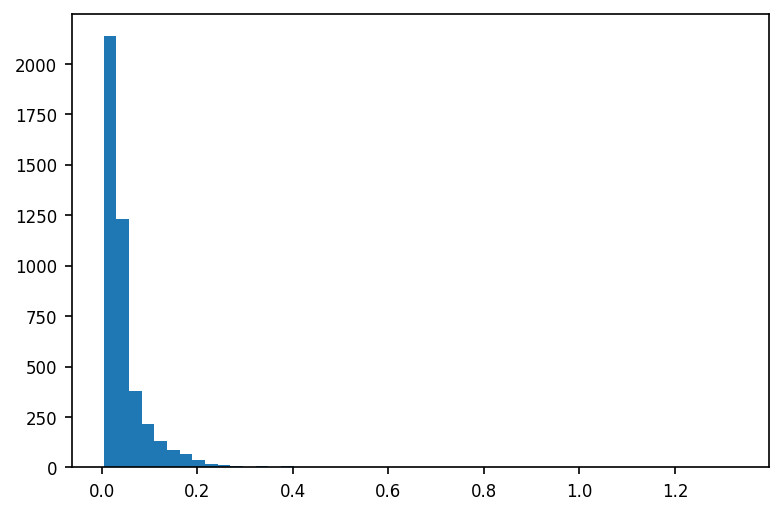

In [121]:
#Rec error without anomaly
fig = plt.figure()
ax=fig.add_subplot(111)
normal_error_df=error_df[(error_df['true_class']==0)]
_ = ax.hist(normal_error_df.reconstruction_error.values,bins=50)

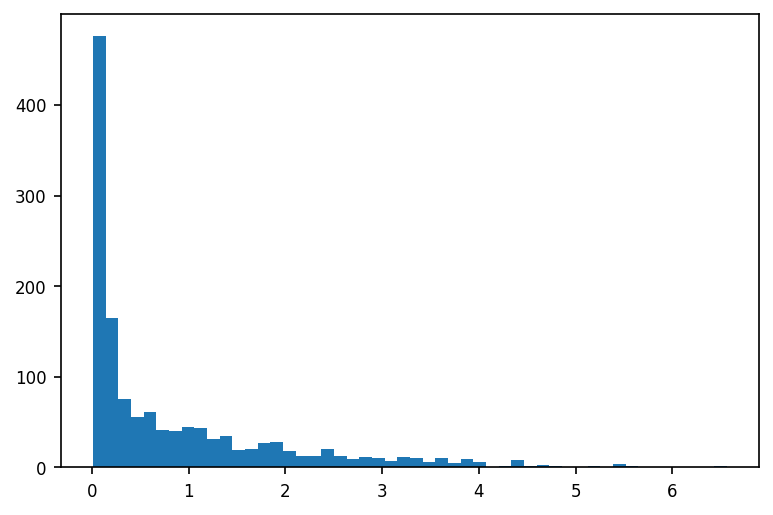

In [122]:
#Rec error with anomaly
fig = plt.figure()
ax=fig.add_subplot(111)
fraud_error_df=error_df[(error_df['true_class']==1)]
_ = ax.hist(fraud_error_df.reconstruction_error.values,bins=50)

In [123]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,accuracy_score,precision_score,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

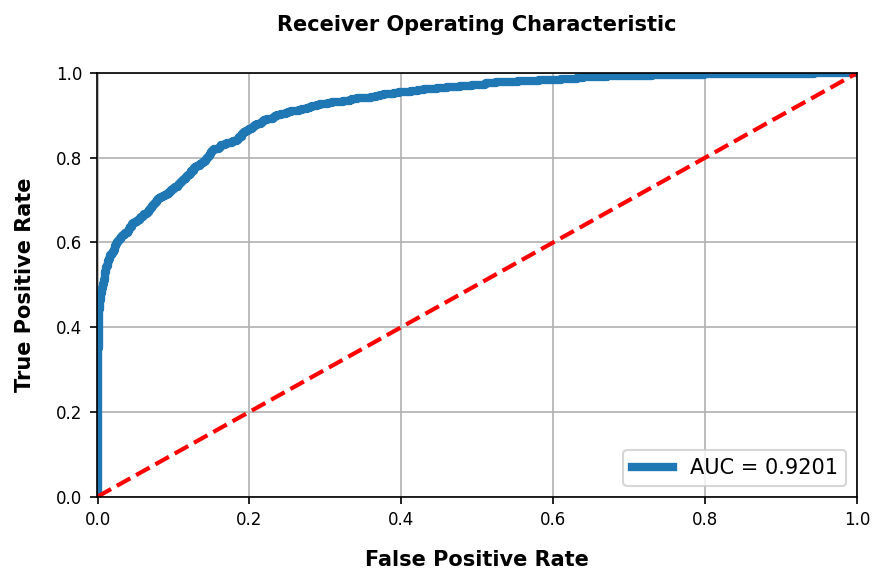

In [124]:
#Precision recall ROC
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic', fontsize=10, fontweight='bold',pad=20)
plt.plot(fpr, tpr, linewidth=4, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right', prop={'size': 10})
plt.plot([0,1],[0,1],'r--', linewidth=2)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate', fontsize=10, fontweight='bold',labelpad=10)
plt.xlabel('False Positive Rate', fontsize=10, fontweight='bold',labelpad=10)
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
plt.grid()
plt.tight_layout()
plt.show()

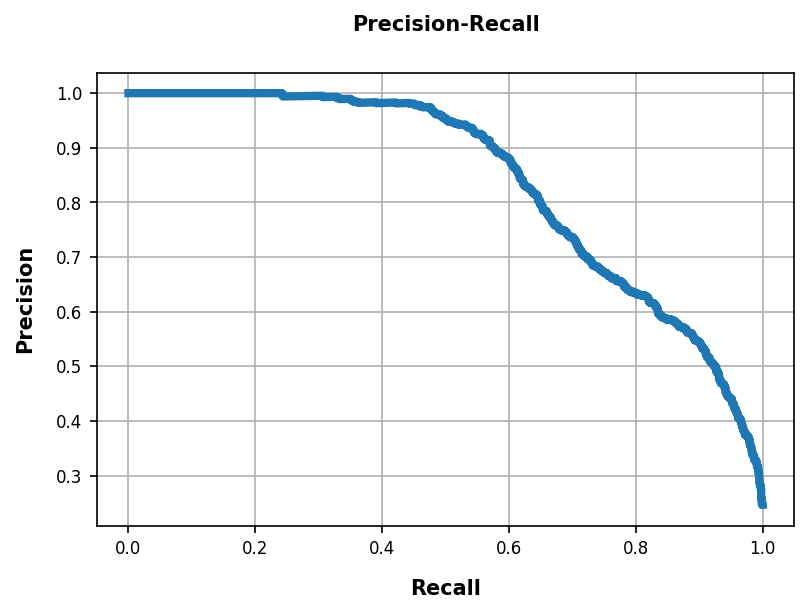

In [125]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, linewidth=4)
plt.title('Precision-Recall', fontsize=10,fontweight='bold',pad=20)
plt.grid()
plt.ylabel('Precision', fontsize=10, fontweight='bold',labelpad=10)
plt.xlabel('Recall', fontsize=10, fontweight='bold',labelpad=10)
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
plt.show()

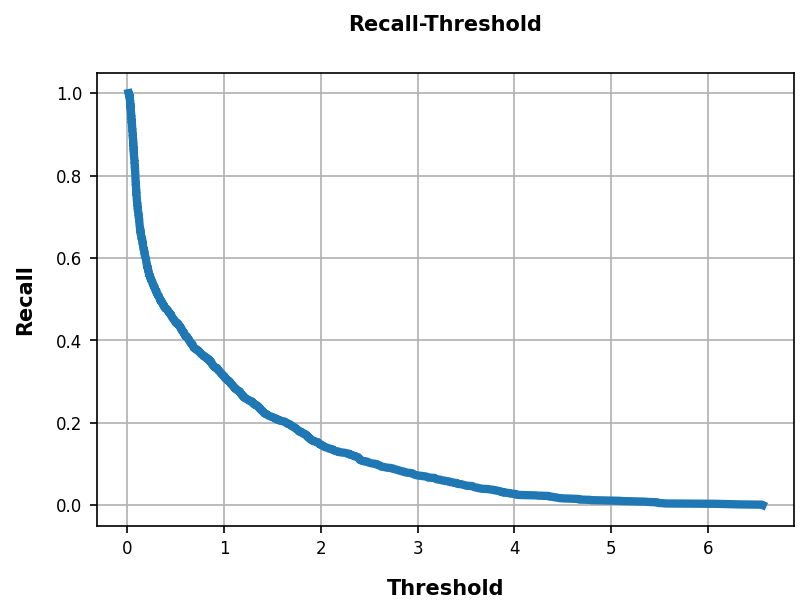

In [126]:
plt.plot(th, recall[:-1], linewidth=4)
plt.title('Recall-Threshold', fontsize=10,fontweight='bold',pad=20)
plt.grid()
plt.ylabel('Recall', fontsize=10, fontweight='bold',labelpad=10)
plt.xlabel('Threshold', fontsize=10, fontweight='bold',labelpad=10)
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
plt.show()

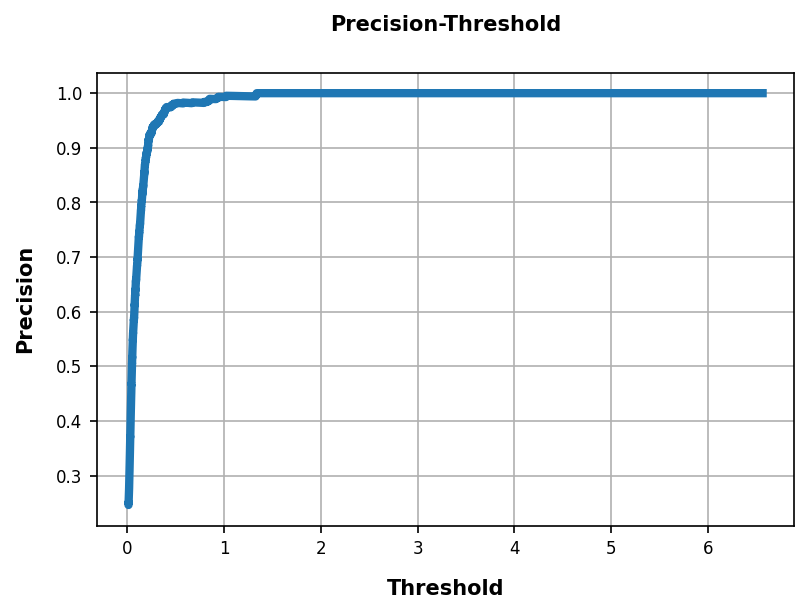

In [127]:
plt.plot(th, precision[:-1], linewidth=4)
plt.title('Precision-Threshold', fontsize=10,fontweight='bold',pad=20)
plt.grid()
plt.ylabel('Precision', fontsize=10, fontweight='bold',labelpad=10)
plt.xlabel('Threshold', fontsize=10, fontweight='bold',labelpad=10)
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
plt.show()

In [128]:
print(th[np.where((recall[:-1]>0.78) & (precision[:-1]>0.65))])

[0.08632796 0.0863474  0.08646731 0.08651884 0.08668353 0.0867687
 0.08681267]


Accuracy: 0.848786
Precision: 0.654769
Recall: 0.777210
F1 score: 0.710755


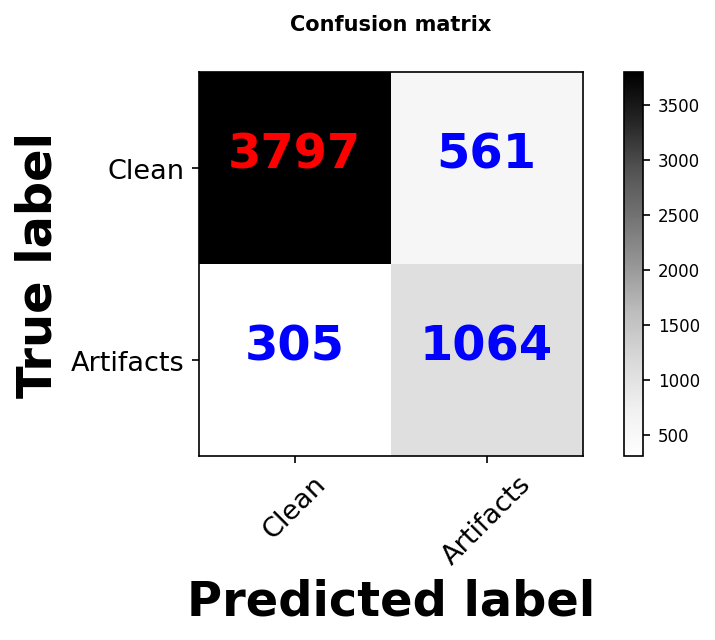

In [129]:
import itertools
#Plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10 ,fontweight='bold',pad=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=23, fontweight='bold',
                 color="red" if cm[i, j] > thresh else "blue")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=23, fontweight='bold')
    plt.xlabel('Predicted label', fontsize=23, fontweight='bold')
c = confusion_matrix(Y_val_ae,validation_set_outputs)
plot_confusion_matrix(c,["Clean","Artifacts"])


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_val_ae, validation_set_outputs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_val_ae, validation_set_outputs)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_val_ae, validation_set_outputs)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_val_ae, validation_set_outputs)
print('F1 score: %f' % f1)

### Testing the model on the testing set

In [130]:
print(X_test_features.shape)

(150, 2, 15)


In [131]:
testing_set_predictions=model.predict(X_test_features)
print(testing_set_predictions.shape)
print("X_test_features ",X_test_features.shape)
test_preds = testing_set_predictions.reshape(testing_set_predictions.shape[0],np.prod(testing_set_predictions.shape[1:]))
print("test_preds ", test_preds.shape)
mse=np.mean(np.power(X_test_features.reshape(X_test_features.shape[0],np.prod(X_test_features.shape[1:]))-test_preds,2),axis=1)
print("mse ", mse.shape)
testing_set_outputs=np.zeros(len(test_preds))
testing_set_outputs[np.where(mse>=threshold)]=1
print("testing_set_outputs ", testing_set_outputs.shape)


5/5 [==============================] - 0s 5ms/step
(150, 2, 15)
X_test_features  (150, 2, 15)
test_preds  (150, 30)
mse  (150,)
testing_set_outputs  (150,)


In [132]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

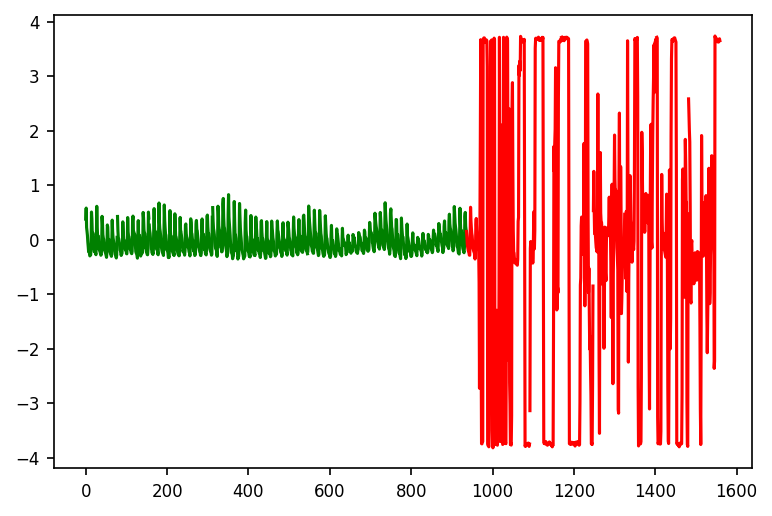

In [133]:
signal = X_test[:20,:,:].flatten()
j=0
for i in range(0,len(signal),X_test.shape[1]):
  if testing_set_outputs[j] == 0:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="green")
  else:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="red")
  j+=1
plt.show()

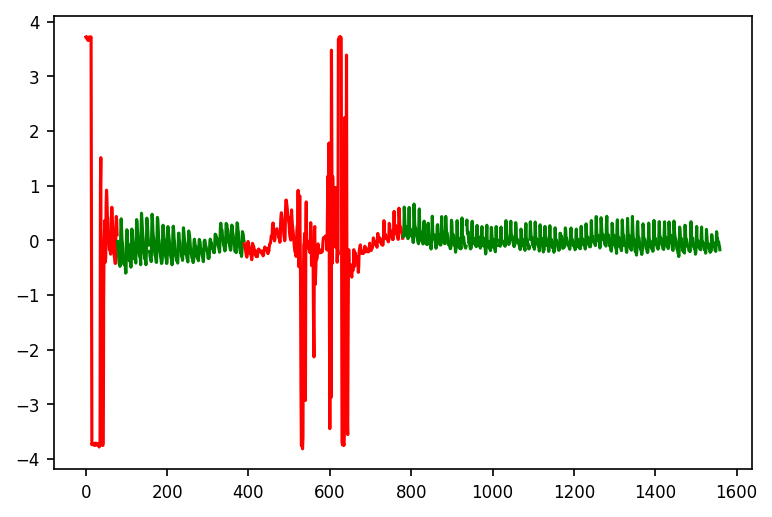

In [134]:
signal = X_test[20:40,:,:].flatten()
j=20
for i in range(0,len(signal),X_test.shape[1]):
  if testing_set_outputs[j] == 0:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="green")
  else:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="red")
  j+=1
plt.show()

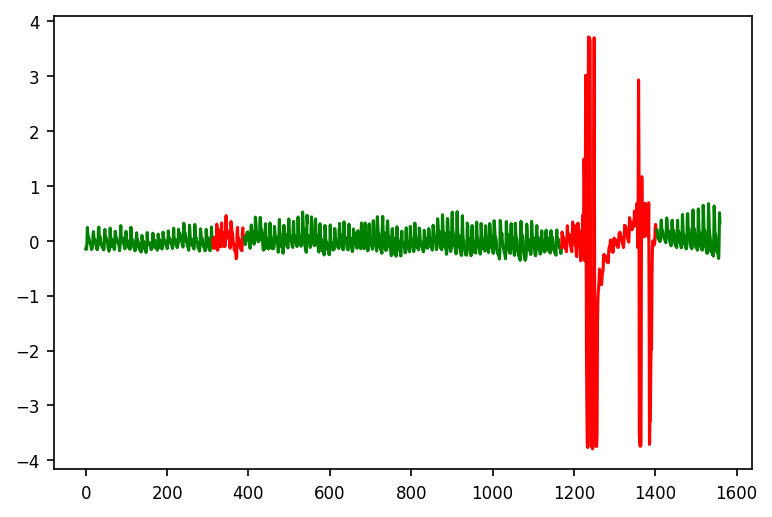

In [135]:
signal = X_test[40:60,:,:].flatten()
j=40
for i in range(0,len(signal),X_test.shape[1]):
  if testing_set_outputs[j] == 0:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="green")
  else:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="red")
  j+=1
plt.show()

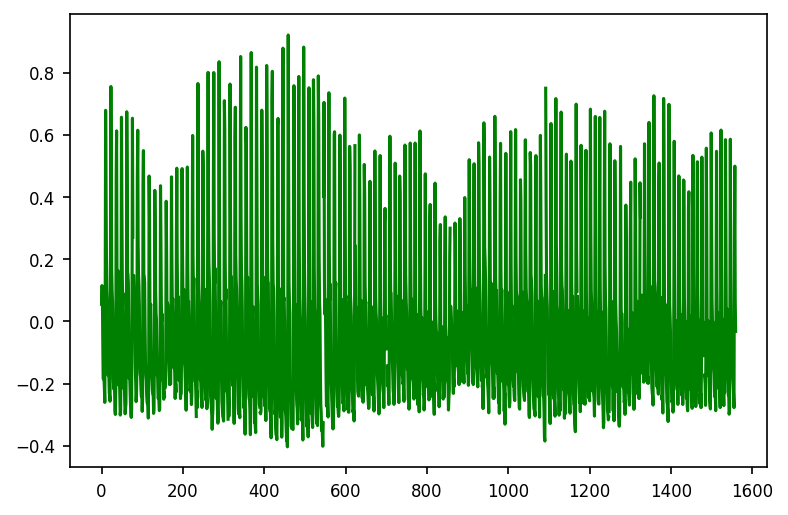

In [136]:
signal = X_test[60:80,:,:].flatten()
j=60
for i in range(0,len(signal),X_test.shape[1]):
  if testing_set_outputs[j] == 0:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="green")
  else:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="red")
  j+=1
plt.show()

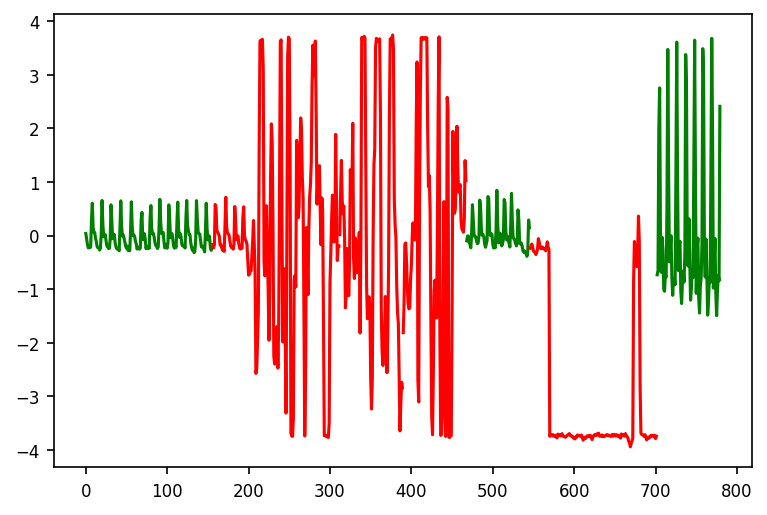

In [137]:
signal = X_test[80:90,:,:].flatten()
j=80
for i in range(0,len(signal),X_test.shape[1]):
  if testing_set_outputs[j] == 0:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="green")
  else:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="red")
  j+=1
plt.show()

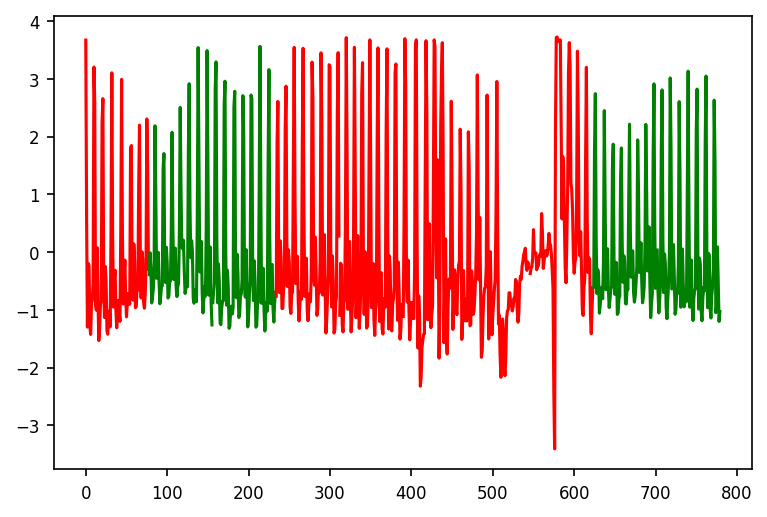

In [138]:
signal = X_test[90:100,:,:].flatten()
j=90
for i in range(0,len(signal),X_test.shape[1]):
  if testing_set_outputs[j] == 0:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="green")
  else:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="red")
  j+=1
plt.show()

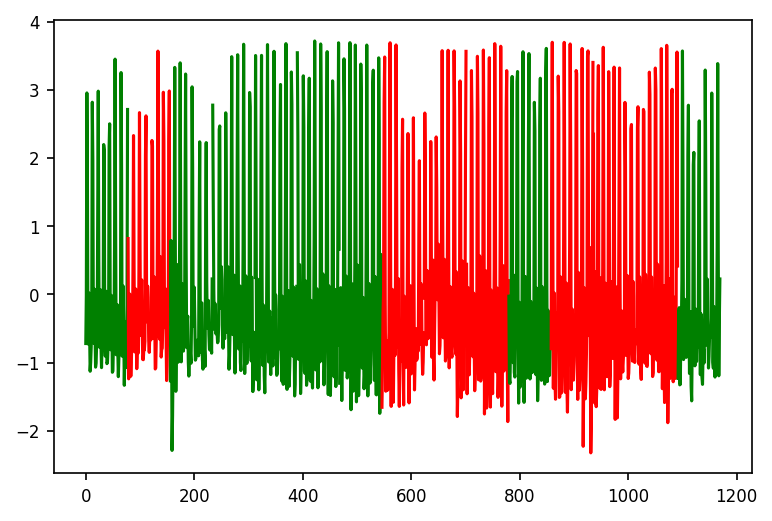

In [139]:
signal = X_test[100:115,:,:].flatten()
j=100
for i in range(0,len(signal),X_test.shape[1]):
  if testing_set_outputs[j] == 0:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="green")
  else:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="red")
  j+=1
plt.show()

Many false positives in the above two figures!

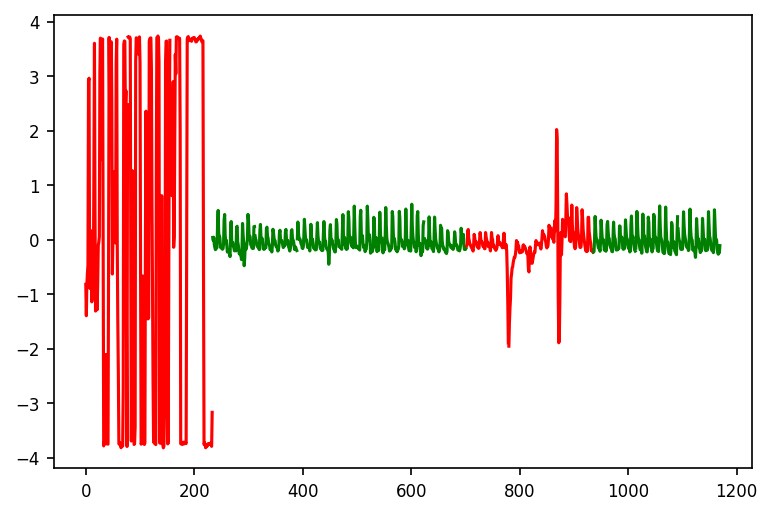

In [140]:
signal = X_test[115:130,:,:].flatten()
j=115
for i in range(0,len(signal),X_test.shape[1]):
  if testing_set_outputs[j] == 0:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="green")
  else:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="red")
  j+=1
plt.show()

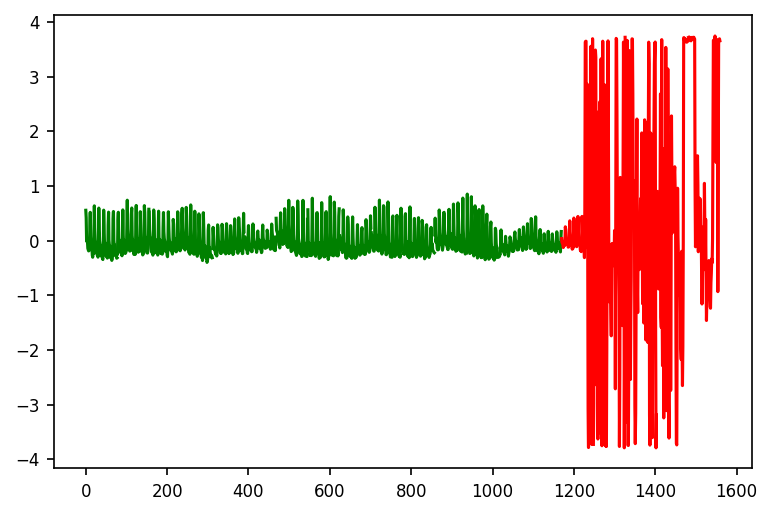

In [141]:
signal = X_test[130:150,:,:].flatten()
j=130
for i in range(0,len(signal),X_test.shape[1]):
  if testing_set_outputs[j] == 0:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="green")
  else:
    plt.plot(list(range(i,i+X_test.shape[1],1)),X_test[j,:,:].flatten(),color="red")
  j+=1
plt.show()